In [1]:
import sys
sys.path.append('..')
from pathlib import Path
import urllib
import gzip
import tempfile
from datetime import datetime
from dateutil import tz

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import xarray as xr
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables

from Map import Map

In [2]:
LOCATION = 'southeast'

Details on the dataset:
https://vlab.noaa.gov/web/wdtd/-/cloud-to-ground-lightning-probability?selectedFolder=668039

In [3]:
def xr_read_compressed_dataset(URL):
    response = urllib.request.urlopen(URL)
    compressed_file = response.read()

    with tempfile.NamedTemporaryFile(suffix='.grib2') as f:
        f.write(gzip.decompress(compressed_file))
        return xr.load_dataset(f.name)

In [4]:
ds = xr_read_compressed_dataset('https://mrms.ncep.noaa.gov/data/2D/LightningProbabilityNext60min/'
                                'MRMS_LightningProbabilityNext60min.latest.grib2.gz')
ds

ECCODES ERROR   :  Truncating time: non-zero seconds(39) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(39) ignored


<xarray.Dataset>
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] 2023-04-29T12:26:00
    step            timedelta64[ns] 00:00:00
    heightAboveSea  float64 500.0
  * latitude        (latitude) float64 54.99 54.98 54.98 ... 20.03 20.02 20.01
  * longitude       (longitude) float64 230.0 230.0 230.0 ... 300.0 300.0 300.0
    valid_time      datetime64[ns] 2023-04-29T12:26:00
Data variables:
    unknown         (latitude, longitude) float32 -9.99e+04 ... -9.99e+04
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2023-04-29T07:29 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
BOTTOM_LAT = 28
TOP_LAT = 34
LEFT_LON = -100
RIGHT_LON = -93

LAT_SLICE = slice(TOP_LAT, BOTTOM_LAT)
LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)

In [6]:
d = ds.sel(latitude=LAT_SLICE, longitude=LON_SLICE)
mrms_values = ds.unknown

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/Chicago')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

VALID_TIME = convert_datetime(str(d.time.values).split('.')[0])

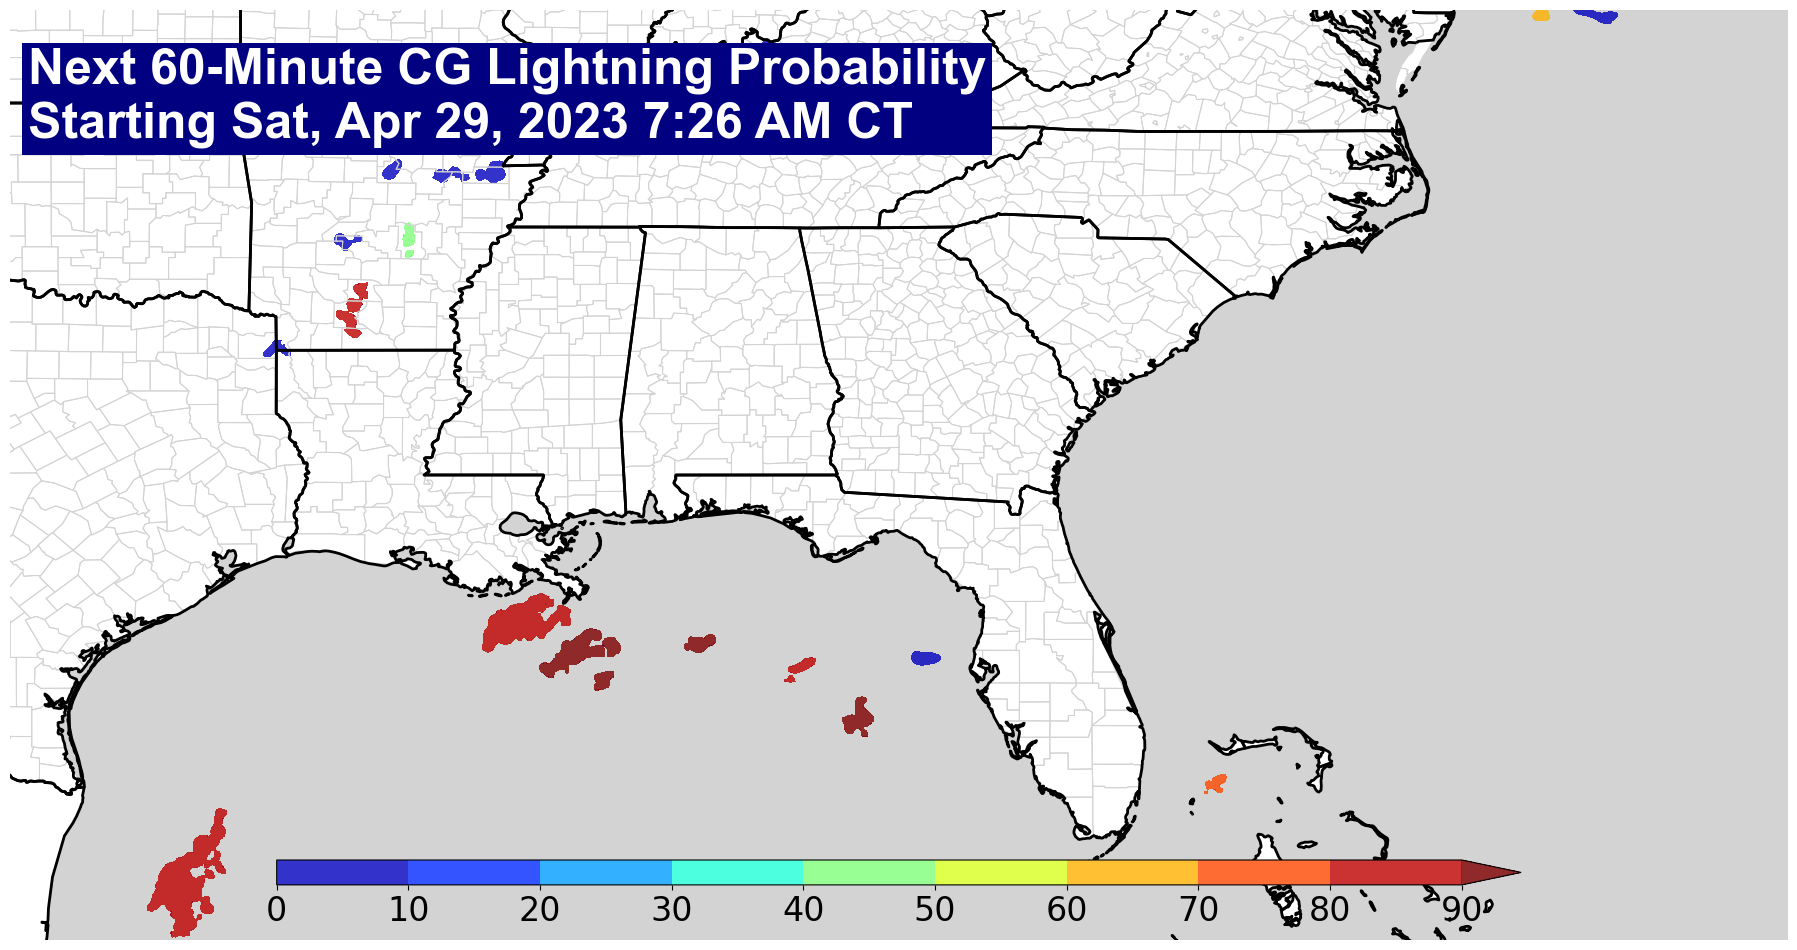

In [10]:
new_map = Map(LOCATION)
new_map.add_counties()
new_map.add_title(f'Next 60-Minute CG Lightning Probability\nStarting {VALID_TIME} CT')

fig, ax = new_map.make_map()

contour = ax.contourf(ds.longitude, ds.latitude, mrms_values, 
                      np.arange(0, 100, 10), 
                      cmap=plt.cm.jet, transform=ccrs.PlateCarree(),
                      alpha=0.8, extend='max')

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, aspect=50, shrink=0.7)
cbar.ax.tick_params(labelsize='24')

# Save and show figure
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'mrms'
plt.savefig(f'{graphics_dir}/lightning-probability.png', dpi=72)
plt.show()